In [1]:
!pip3 install statsmodels


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import hilbertcurve.hilbertcurve as hcurve
from hilbertcurve.hilbertcurve import HilbertCurve
import socket, struct
import scipy.sparse as spar
import seaborn as sns
from datetime import datetime
import ipaddress
from collections import defaultdict
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
import statsmodels.api as sm
import matplotlib.dates as mdates
from scipy.stats import entropy

sns.set()

In [3]:
f = 'zanbil/access.log'

In [4]:
# 1+1: Tue Aug 22 00:00:00 1995

data = {'Timestamp': [], 'Src IP': []}

# 178.47.232.191 22/Jan/2019:04:54:22 +0330 GET 400 166 - Yowai/2.0 -


regex = r'^(?<IP_ADDRESS>\d{3}.\d{3}.\d{3}).(?<DATE_TIME>20\d{2}-\d{2}-\d{2}:\d{2}:\d{2}+\d{3}).(?<REQUEST_TYPE>\w).(?<REQUEST_STATUS>\d{3}).(?<RESPONSE_SIZE>\d{3}).(?<USER_AGENT>\w).(?<REFERER>\w)'

for line in open(f):
    

    # Extract the IP address and timestamp from the log line
    ip_address, line = line.split(' ',1)
    # Define a regular expression to match the timestamp
    timestamp_regex = r"\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} [+|-]\d{4}"

    # Use the regular expression to search for the timestamp in the string
    match = re.search(timestamp_regex, line)

    if match:
        # If a match is found, print the timestamp
        timestamp = match.group()
    else:
        # If no match is found, print an error message
        print("No timestamp found in the string.")
        break


    
    data['Src IP'].append(ip_address)
    data['Timestamp'].append(timestamp)


In [5]:
df = pd.DataFrame(data)

In [6]:
df.head()

,Timestamp,Src IP
0,22/Jan/2019:03:56:14 +0330,54.36.149.41
1,22/Jan/2019:03:56:16 +0330,31.56.96.51
2,22/Jan/2019:03:56:16 +0330,31.56.96.51
3,22/Jan/2019:03:56:17 +0330,40.77.167.129
4,22/Jan/2019:03:56:17 +0330,91.99.72.15


In [7]:
format_str = "%d/%b/%Y:%H:%M:%S %z"
def preprocess_timeseries(df):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'],format=format_str)
    # Set the Timestamp column as the DataFrame index
    df.set_index('Timestamp', inplace=True)

preprocess_timeseries(df)

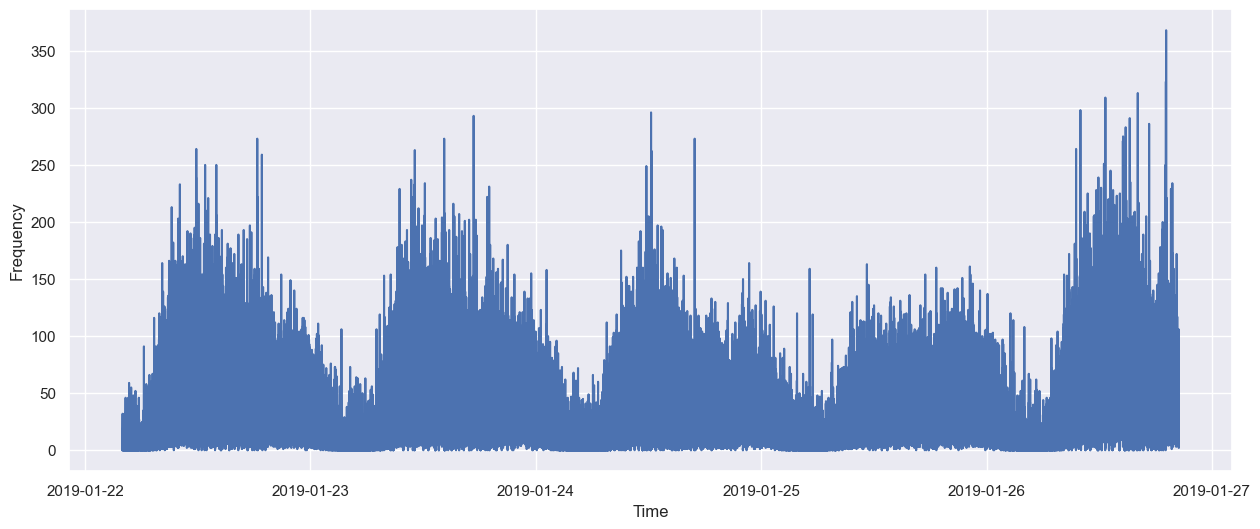

In [8]:
def plot_timeseries(df):
    # Resample the DataFrame to one-second intervals and count the number of occurrences
    resampled = df['Src IP'].resample('1S').count()

    # Plot the resampled data
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(resampled.index, resampled.values)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    plt.show()

    return resampled

timeseries_df = plot_timeseries(df)

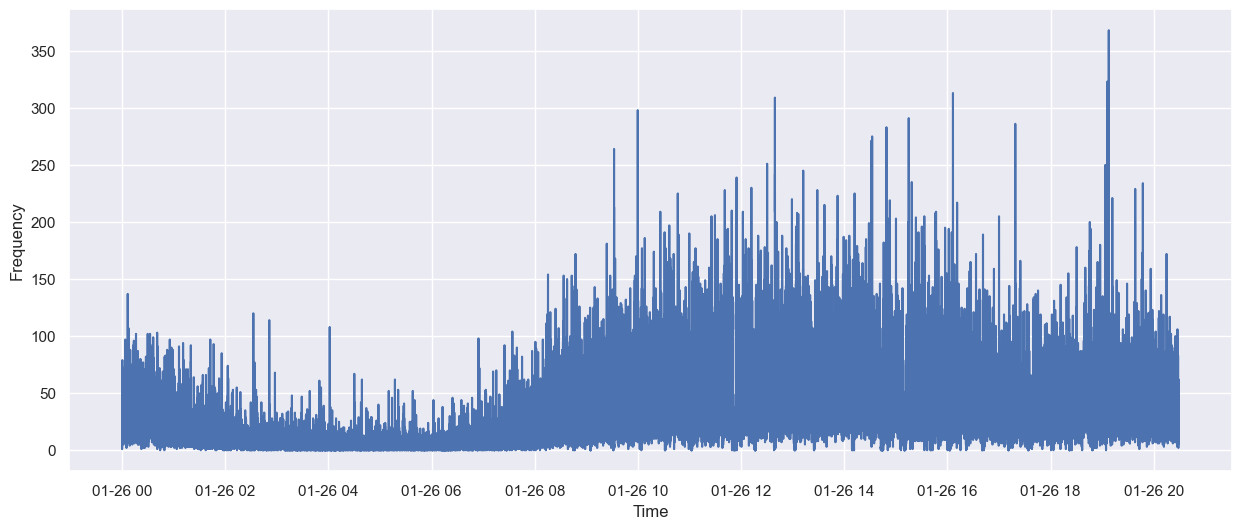

In [9]:
# Date with the maximum value
max_timestamp = timeseries_df.idxmax()
mask = df.index.date == max_timestamp.date()
filtered_df = df.loc[mask]

timeseries_df = plot_timeseries(filtered_df)

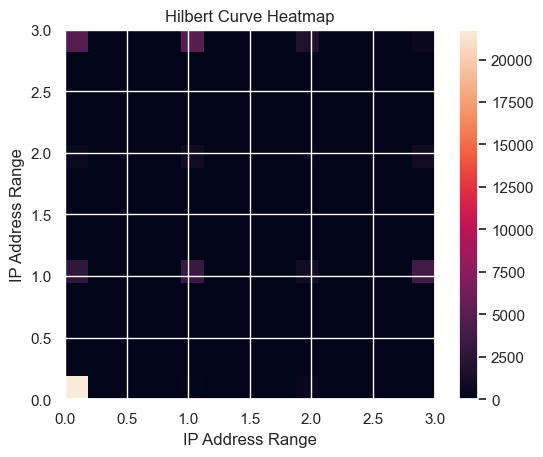

47970
2174497


In [10]:

def convert_ip_to_int(ip):
    return struct.unpack("!I", socket.inet_aton(ip))[0]


def convert_ips_to_hilbert_curve(ips):
    
    mapper = {} # to keep track which int ip is mapped to which index
    
    import numpy as np
    from hilbertcurve.hilbertcurve import HilbertCurve
    import matplotlib.pyplot as plt
    import socket, struct
    import scipy.sparse as sparse
    from PIL import Image
    sns.set()
    # convert IP addresses to integers
    int_ips = np.array([convert_ip_to_int(ip) for ip in ips])
    
    # map integer IPs to Hilbert curve index
    max_index = 2**32 - 1 # maximum possible integer IP
    num_points = len(int_ips)
    order = int(round((num_points**0.5) / 2.0)) # Hilbert curve order
    order = 4
    n_points = len(int_ips)
    # order = n_points

    hilbert_curve = HilbertCurve(order, 2, n_procs=-1) # 2-dimensional curve

    indexes = np.array(int_ips * (2**order) / max_index)
    indexes = np.round(np.unique(indexes)) # remove duplicates for faster indexing
    coords = np.array(hilbert_curve.points_from_distances(indexes))

    # create heatmap using numpy and matplotlib
    heatmap, xedges, yedges = np.histogram2d(coords[:, 0], coords[:, 1], bins=2**order)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.imshow(heatmap.T, extent=extent, origin='lower')

    
    
    # tick_positions = np.linspace(0, max_distance, num=5, dtype=int)
    # tick_labels = [int_to_ip_bytes(int(hilbert_curve.point_from_distance(d))[0]) for d in tick_positions]
    # plt.xticks(tick_positions, tick_labels, rotation=90)
    # plt.yticks(tick_positions, tick_labels)

    # Set the plot title and axis labels
    plt.title('Hilbert Curve Heatmap')
    plt.xlabel('IP Address Range')
    plt.ylabel('IP Address Range')

    plt.colorbar()
    plt.show()
    
    print(len(coords))
    print(len(ips))

convert_ips_to_hilbert_curve(filtered_df['Src IP'])

In [11]:
def convert_ip_to_int2(ip):
    # Convert the IP address to an integer
    ip_int = int(ipaddress.IPv4Address(ip_str))

    # Convert each integer part of the IP address to a binary string and concatenate them
    ip_parts = (ip_int >> 24, (ip_int >> 16) & 255, (ip_int >> 8) & 255, ip_int & 255)
    binary_str = ''.join(format(p, '08b') for p in ip_parts)

    # Convert each integer part of the IP address to a binary string and concatenate them
    ip_parts = (ip_int >> 24, (ip_int >> 16) & 255, (ip_int >> 8) & 255, ip_int & 255)
    binary_str = ''.join(format(p, '08b') for p in ip_parts)

    # Convert the binary string to a 128-bit integer
    ip_int128 = int(binary_str, 2)
    return ip_int128

def convert_ip_to_int(ip):
    return struct.unpack("!I", socket.inet_aton(ip))[0]

def convert_ip_to_hc_coord(ips):
    ip_to_hc = defaultdict(list)
    hc_to_ip = defaultdict(list)
    
        
    set_ips = set(ips)
    
    map_ips = {}
    for i,ip in enumerate(set_ips):
        val = convert_ip_to_int(ip)
        map_ips[val] = i
    coords = []    
    n = 2
    bits = 64
    # Compute the Hilbert coordinate for the 128-bit integer
    hc = HilbertCurve(bits, n, n_procs=-1)
    coords_set = hc.points_from_distances(map_ips.keys())
    
    coords = []
    for ip in ips:
        int_ip = convert_ip_to_int(ip)
        index = map_ips[int_ip]
        coord = coords_set[index]
        coords.append(coord)
    return coords

coords = convert_ip_to_hc_coord(filtered_df['Src IP'])

In [12]:
filtered_df = filtered_df.copy()
filtered_df['Coords'] = coords

In [13]:
filtered_df.head()

,Src IP,Coords
Timestamp,,
2019-01-26 00:00:00+03:30,66.249.66.194,"[7710, 37782]"
2019-01-26 00:00:00+03:30,82.223.37.82,"[5250, 56254]"
2019-01-26 00:00:00+03:30,54.36.149.22,"[10616, 19214]"
2019-01-26 00:00:00+03:30,82.223.37.82,"[5250, 56254]"
2019-01-26 00:00:00+03:30,130.185.76.185,"[40012, 39401]"


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/clust

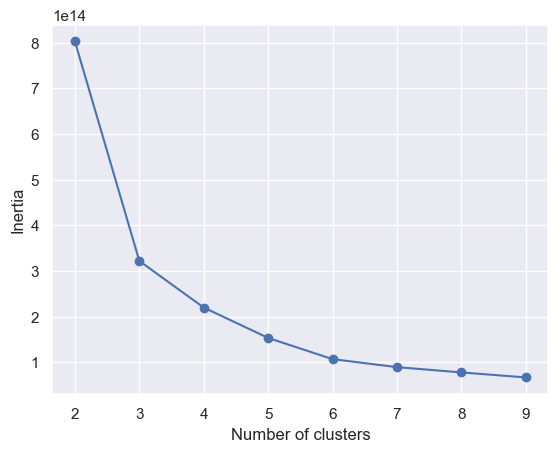

In [14]:
# extract the Coords column as a numpy array
coords = np.array(filtered_df['Coords'].tolist())

# Define range of cluster numbers to try
cluster_range = range(2, 10)

# Initialize list to store scores for each cluster number
scores = []

# Loop through cluster numbers and calculate KMeans score for each
for n in cluster_range:
    kmeans = KMeans(n_clusters=n, random_state=0)
    kmeans.fit(coords)
    inertia = kmeans.inertia_
    scores.append(inertia)

# Plot the scores for each cluster number
plt.plot(cluster_range, scores, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [15]:


# cluster the coords array using K-Means
kmeans = KMeans(n_clusters=4, random_state=0).fit(coords)
labels = kmeans.labels_

# add the cluster labels as a new column to the original DataFrame
filtered_df['Cluster'] = labels


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


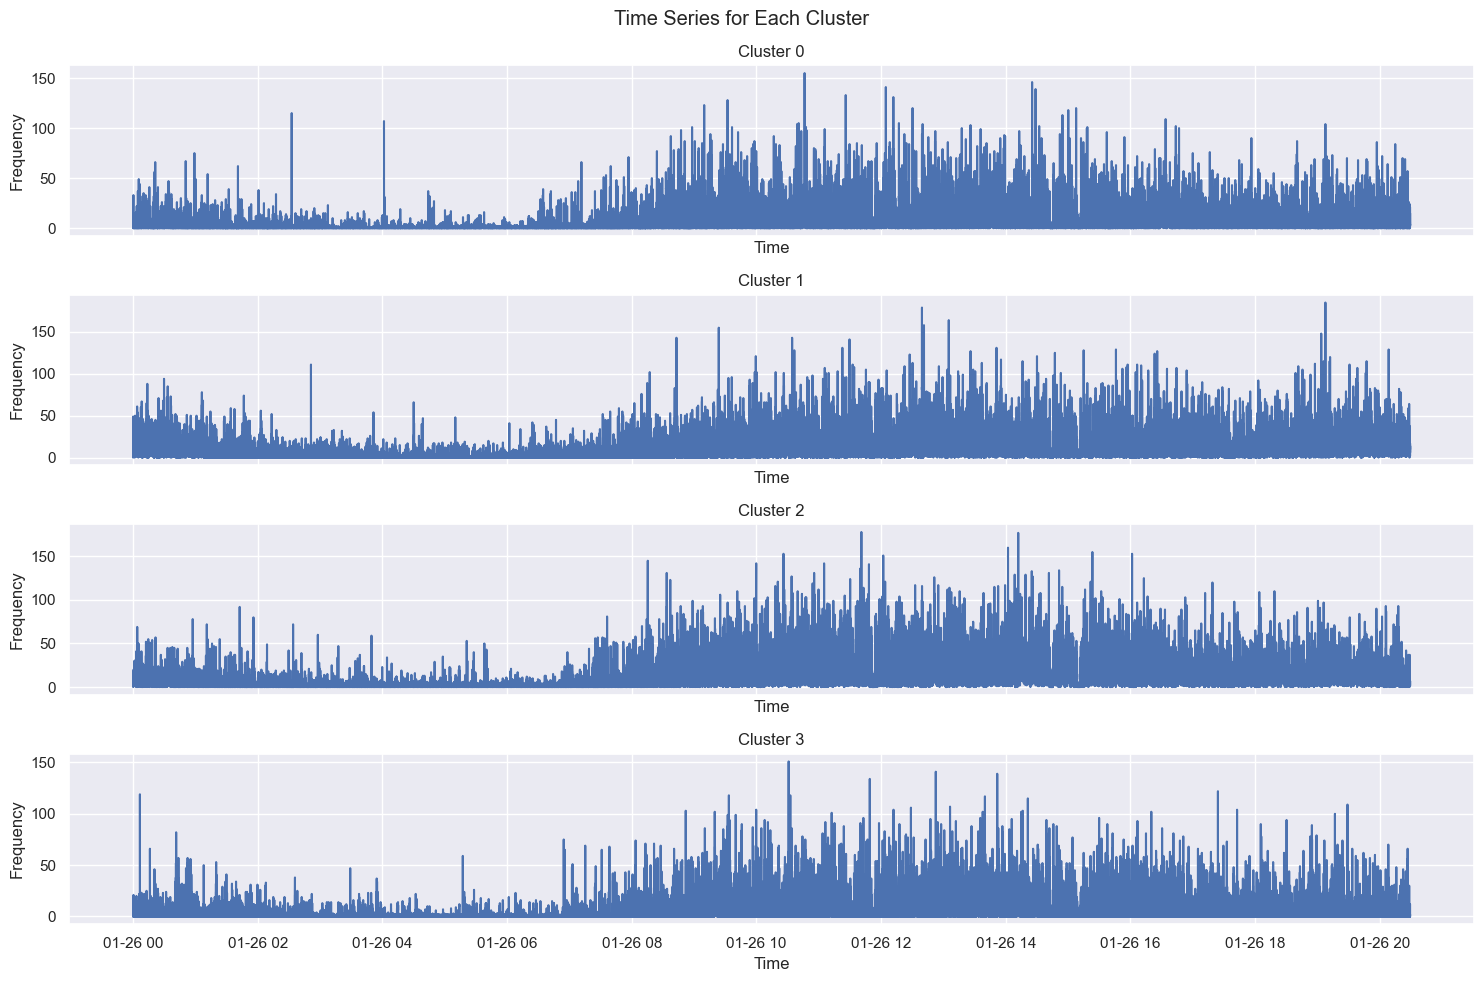

In [16]:

fig, axes = plt.subplots(nrows=len(np.unique(labels)), sharex=True, figsize=(15, 10))
# iterate over the clusters and plot the time series for each cluster
for i, label in enumerate(np.unique(labels)):
    # filter the DataFrame for the current cluster
    cluster_df = filtered_df[filtered_df['Cluster'] == label]
    
    # resample the DataFrame to one-second intervals and count the number of occurrences
    resampled = cluster_df['Src IP'].resample('1S').count()
    
    # plot the resampled data on the corresponding subplot
    ax = axes[i]
    ax.plot(resampled.index, resampled.values)
    ax.set_title(f'Cluster {label}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')

# set the overall title of the figure
fig.suptitle('Time Series for Each Cluster')

# adjust the layout of the subplots to avoid overlapping
fig.tight_layout()

# show the plot
plt.show()

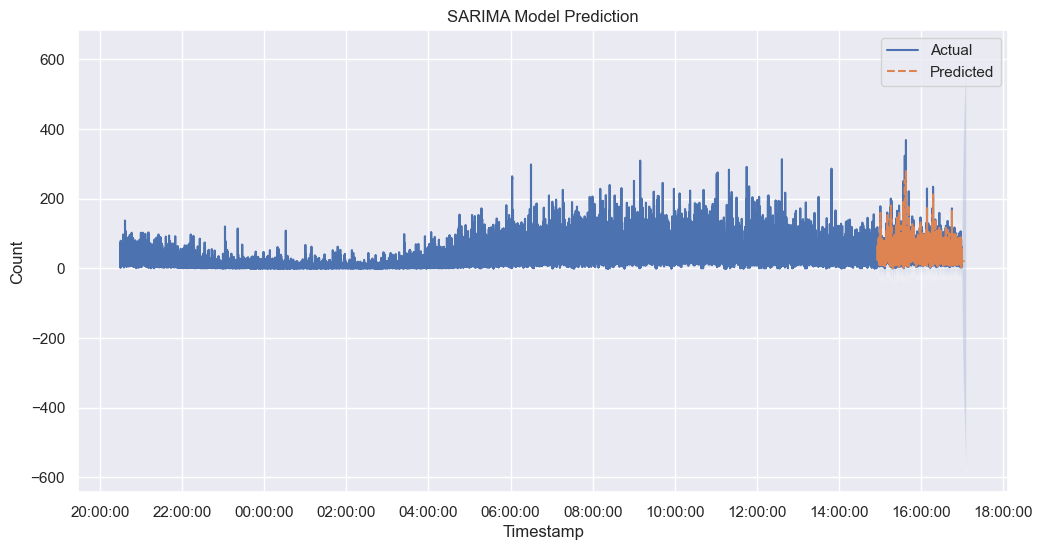

In [17]:

from statsmodels.tsa.arima.model import ARIMA


# create a SARIMA model with (p, d, q) = (1, 1, 1) and (P, D, Q, s) = (0, 1, 1, 60)
model = ARIMA(timeseries_df, order=(1,1,0))
results = model.fit()

# predict the values for the next 10%
threshold = int(len(timeseries_df) * .10)
pred = results.get_prediction(start=timeseries_df.index[-threshold], end=timeseries_df.index[-1] + pd.Timedelta(seconds=threshold/20), dynamic=False)

# extract the predicted values, the lower and upper confidence intervals
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

# plot the actual values, the predicted values, and the error margins
fig, ax = plt.subplots(figsize=(12, 6))

# plot the actual values
ax.plot(timeseries_df.index, timeseries_df, label='Actual')

# plot the predicted values
ax.plot(pred_mean.index, pred_mean, label='Predicted', linestyle='--')

# plot the error margins
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], alpha=0.2)

# set the axis labels and title
ax.set_xlabel('Timestamp')
ax.set_ylabel('Count')
ax.set_title('SARIMA Model Prediction')


# Set the date ticks
date_fmt = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

# show the legend
ax.legend()

plt.show()


In [18]:
from sklearn.metrics import mean_absolute_percentage_error

# make predictions using the SARIMA model
predictions = results.get_prediction(start=timeseries_df.index[-threshold], end=timeseries_df.index[-1], dynamic=True)

test_values = timeseries_df.loc[timeseries_df.index[-threshold]:timeseries_df.index[-1]]

# calculate the absolute error
abs_error = abs(test_values - predictions.predicted_mean)

# print(sorted(abs_error/test_values,reverse=True))


# calculate the percentage error
pct_error = 100*abs_error / (1e-10 + test_values)

print('Percentage Error',np.mean(pct_error))

Percentage Error 29288135644.52954


In [19]:
# calculate the absolute error
abs_error = abs(test_values - predictions.predicted_mean)

# calculate the percentage error
pct_error = abs_error / test_values * 100

print('Percentage Error',np.median(pct_error))

Percentage Error 35.714285714285715


In [20]:
import numpy as np

# Compute one-step-ahead forecast errors
one_step_ahead_forecast_errors = test_values - predictions.predicted_mean

# Compute mean absolute error (MAE) of one-step-ahead forecast errors
MAE = np.mean(np.abs(one_step_ahead_forecast_errors))

# Compute naive forecast errors
naive_forecast_errors = test_values.diff().iloc[1:]

# Compute MAE of naive forecast errors
naive_MAE = np.mean(np.abs(naive_forecast_errors))

# Compute MASE
MASE = MAE / naive_MAE


In [21]:
MASE

1.1020250261848747

In [22]:
filtered_df.head()

,Src IP,Coords,Cluster
Timestamp,,,
2019-01-26 00:00:00+03:30,66.249.66.194,"[7710, 37782]",2
2019-01-26 00:00:00+03:30,82.223.37.82,"[5250, 56254]",2
2019-01-26 00:00:00+03:30,54.36.149.22,"[10616, 19214]",1
2019-01-26 00:00:00+03:30,82.223.37.82,"[5250, 56254]",2
2019-01-26 00:00:00+03:30,130.185.76.185,"[40012, 39401]",0


In [23]:
# # Group by timestamp and IP address, and count the occurrences of each IP address
# grouped = filtered_df.groupby(['Timestamp', 'Src IP'])['Src IP'].count().reset_index(name='Count')

# # Create a pivot table
# pivot = pd.pivot_table(grouped, values='Count', index=['Timestamp'], columns=['Src IP'], fill_value=0)

# # Plot the pivot table as a heatmap
# plt.figure(figsize=(15, 10))
# sns.heatmap(pivot, cmap='Blues')
# plt.title('IP Address Distribution over Time')
# plt.xlabel('IP Address')
# plt.ylabel('Timestamp')
# plt.show()

# # Calculate the entropy of the IP address distribution for each timestamp
# entropies = pivot.apply(lambda row: entropy(row, base=2), axis=1)

# # Plot the entropy over time
# plt.figure(figsize=(15, 5))
# plt.plot(entropies.index, entropies.values)
# plt.title('Entropy of IP Address Distribution over Time')
# plt.xlabel('Timestamp')
# plt.ylabel('Entropy')
# plt.show()

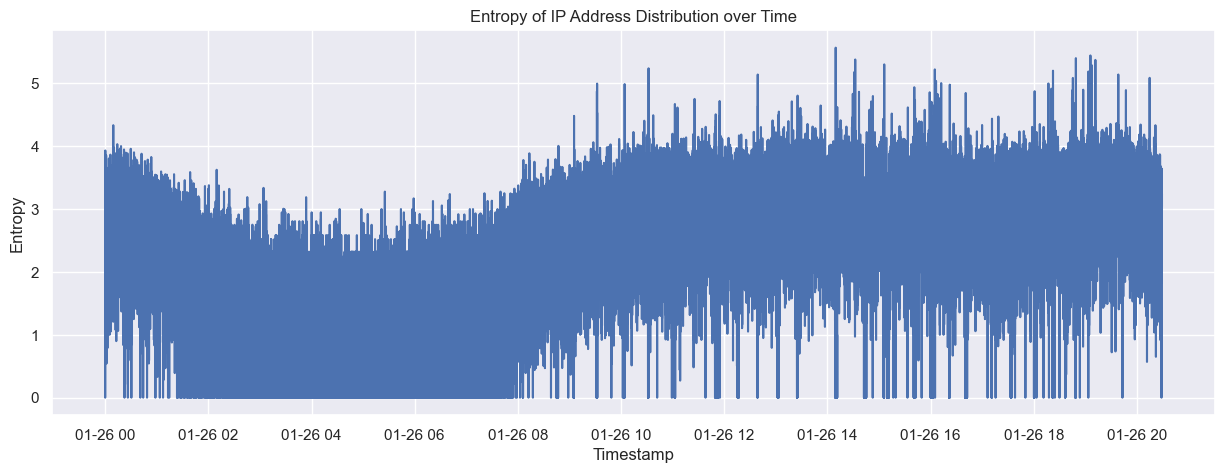

In [24]:
entropies = filtered_df.groupby('Timestamp')['Src IP'].apply(lambda x: entropy(x.value_counts(normalize=True), base=2))
plt.figure(figsize=(15, 5))
plt.plot(entropies.index, entropies.values)
plt.title('Entropy of IP Address Distribution over Time')
plt.xlabel('Timestamp')
plt.ylabel('Entropy')
plt.show()

In [25]:
len(set(filtered_df['Src IP']))

47970

In [26]:
len(filtered_df['Src IP'])

2174497

In [27]:
x = filtered_df['Src IP']
x = filtered_df.iloc[: len(x)*1//4]

In [28]:
len(x)

543624

In [29]:
freq_table = x['Src IP'].value_counts()


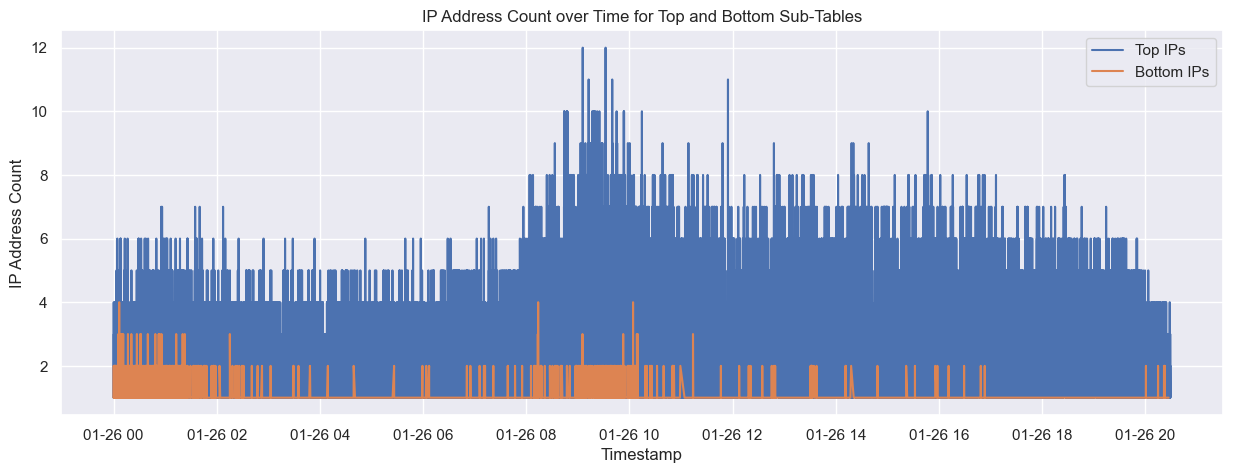

In [30]:
# Find the maximum value (1% percentile) and minimum value (1) in the freq_table
max_value = freq_table.quantile(0.99)
min_value = freq_table.quantile(0.01)

# Create two sub-tables based on the maximum and minimum values
top_ips = filtered_df[filtered_df['Src IP'].isin(freq_table[freq_table >= max_value].index)]
bottom_ips = filtered_df[filtered_df['Src IP'].isin(freq_table[freq_table <= min_value].index)]

# Group the sub-tables by timestamp and calculate the IP address count for each group
top_ips_count = top_ips.groupby('Timestamp')['Src IP'].nunique()
bottom_ips_count = bottom_ips.groupby('Timestamp')['Src IP'].nunique()

# Plot the IP address count over time for the top and bottom sub-tables
plt.figure(figsize=(15, 5))
plt.plot(top_ips_count.index, top_ips_count.values, label='Top IPs')
plt.plot(bottom_ips_count.index, bottom_ips_count.values, label='Bottom IPs')
plt.title('IP Address Count over Time for Top and Bottom Sub-Tables')
plt.xlabel('Timestamp')
plt.ylabel('IP Address Count')
plt.legend()
plt.show()

In [31]:
# Define a function to calculate entropy
def entropy_fn(data):
    p_data = data.value_counts() / len(data) # calculate the probabilities
    # TODO: check base log
    e = entropy(p_data)  # calculate entropy
    return e

# Calculate the entropy of the top_ips and bottom_ips sub-tables over time
top_ips_entropy = top_ips.groupby('Timestamp')['Src IP'].apply(entropy_fn)
bottom_ips_entropy = bottom_ips.groupby('Timestamp')['Src IP'].apply(entropy_fn)


# Create a figure with two subplots, one for entropy and one for IP address count
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,10))

# Plot the entropy over time for the top and bottom sub-tables on the first subplot
ax1.plot(top_ips_entropy.index, top_ips_entropy.values, label='Top IPs', color='blue')
ax1.plot(bottom_ips_entropy.index, bottom_ips_entropy.values, label='Bottom IPs', color='orange')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Entropy')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')
ax1.set_title('Entropy over Time for Top and Bottom Sub-Tables')

# Group the sub-tables by timestamp and calculate the IP address count for each group
top_ips_count = top_ips.groupby('Timestamp')..nunique()
bottom_ips_count = bottom_ips.groupby('Timestamp')['Src IP'].nunique()

# Plot the IP address count over time for the top and bottom sub-tables on the second subplot
ax2.plot(top_ips_count.index, top_ips_count.values, label='Top IPs Count', color='blue', linestyle='--')
ax2.plot(bottom_ips_count.index, bottom_ips_count.values, label='Bottom IPs Count', color='orange', linestyle='--')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('IP Address Count')
ax2.tick_params(axis='y')
ax2.legend(loc='upper left')
ax2.set_title('IP Address Count over Time for Top and Bottom Sub-Tables')

plt.tight_layout()
plt.show()


SyntaxError: invalid syntax (3468276265.py, line 26)

In [ ]:
sample = top_ips.groupby('Timestamp')

In [ ]:
sample.head()

In [ ]:
# no of unique ips over time